### Looking at speaker demographics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

import scipy
from scipy import stats

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# Dataframe with american speakers in Quotebank and their information
americans = pd.read_csv("data/americans.csv")

In [3]:
americans.head()

,Unnamed: 0,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,1,['George Walker Bush' 'Bush Jr.' 'Dubya' 'GWB'...,['+1946-07-06T00:00:00Z'],['Q30'],['Q6581097'],1395142029,NaN,NaN,['Q82955' 'Q15982858' 'Q18814623' 'Q1028181' '...,['Q29468'],NaN,Q207,George W. Bush,['Q327959' 'Q464075' 'Q3586276' 'Q4450587'],item,['Q329646' 'Q682443' 'Q33203']
1,2,['Neil Percival Young' 'Shakey' 'Godfather of ...,['+1945-11-12T00:00:00Z'],['Q16' 'Q30'],['Q6581097'],1395459626,NaN,NaN,['Q177220' 'Q488205' 'Q2526255' 'Q639669' 'Q18...,NaN,NaN,Q633,Neil Young,NaN,item,NaN
2,3,['Mary Louise Streep' 'Meryl Louise Streep' 'S...,['+1949-06-22T00:00:00Z'],['Q30'],['Q6581072'],1388232380,NaN,NaN,['Q10800557' 'Q2259451' 'Q10798782' 'Q2405480'...,['Q29552'],NaN,Q873,Meryl Streep,NaN,item,['Q7066']
3,4,NaN,['+1947-10-01T00:00:00Z'],['Q30'],['Q6581097'],1291441158,NaN,NaN,['Q3630699' 'Q54845077'],NaN,NaN,Q1381,Dave Arneson,NaN,item,NaN
4,5,['Ashton James Eaton'],['+1988-01-21T00:00:00Z'],['Q30'],['Q6581097'],1395347414,['Q49085'],NaN,['Q14605941'],NaN,NaN,Q1789,Ashton Eaton,NaN,item,NaN


In [4]:
americans = americans.fillna("['Q0']")

In [2]:
# Dataframes with quotes from americans
df15_all = pd.read_csv("data/df15_all.csv")
df16_all = pd.read_csv("data/df16_all.csv")
df17_all = pd.read_csv("data/df17_all.csv")
df18_all = pd.read_csv("data/df18_all.csv")
df19_all = pd.read_csv("data/df19_all.csv")
df20_all = pd.read_csv("data/df20_all.csv")

In [6]:
# Unique speakers for each year
speakers15 = df15_all.speaker.unique()
speakers16 = df16_all.speaker.unique()
speakers17 = df17_all.speaker.unique()
speakers18 = df18_all.speaker.unique()
speakers19 = df19_all.speaker.unique()
speakers20 = df20_all.speaker.unique()

speakers = [speakers15, speakers16, speakers17, speakers18, speakers19, speakers20]

In [7]:
# Number of unique speakers per year
total15 = len(speakers15)
total16 = len(speakers16)
total17 = len(speakers17)
total18 = len(speakers18)
total19 = len(speakers19)
total20 = len(speakers20)

totals = [total15, total16, total17, total18, total19, total20]

In [8]:
years = [2015, 2016, 2017, 2018, 2019, 2020]

### Political Party of Speakers

In [9]:
# Create a dataframe with the counts of each political party QID for each year
pol_party = pd.DataFrame()
for i, s in enumerate(speakers):
    parties = pd.DataFrame(americans[americans.label.isin(s)].drop_duplicates(subset=['label']).party)
    parties.party = parties.party.astype(str)
    parties.party = parties.party.map(lambda x: x.lstrip("['").rstrip("]'"))
    parties.party = parties.party.map(lambda x: x.replace("' '", ' '))
    parties = parties[~(parties.party == 'nan')]
    parties = parties.value_counts().head(10)
    parties = pd.DataFrame(parties).reset_index()
    parties.columns = ['qid', 'ct']
    parties['year'] = i+2015
    pol_party = pol_party.append(parties)
pol_party.head()

,qid,ct,year
0,Q0,5375,2015
1,Q29552,715,2015
2,Q29468,494,2015
3,Q29468 Q29552,16,2015
4,Q29552 Q29468,13,2015


In [10]:
# Create a dataframe with the political party QIDs and their labels
qids = ['Q29552', 'Q29468', 'Q29468 Q29552', 'Q29552 Q29468', 'Q1937395 Q29552',
       'Q5020399', 'Q327591', 'Q0']
labels = ['democrat', 'republican', 'democrat/republican', 'democrat/republican', 'minnesota democrat-farmer-labor', 'democrat', 'independent', 'unknown']

data = list(zip(qids, labels))
party_QID = pd.DataFrame(data, columns = ['qid', 'party'])
party_QID.head()

,qid,party
0,Q29552,democrat
1,Q29468,republican
2,Q29468 Q29552,democrat/republican
3,Q29552 Q29468,democrat/republican
4,Q1937395 Q29552,minnesota democrat-farmer-labor


In [11]:
# Merge the two dataframes to get the labels and the counts together
merged_party = pd.merge(pol_party, party_QID)
merged_party = merged_party[merged_party.qid != 'Q0']
merged_party.head()

,qid,ct,year,party
6,Q29552,715,2015,democrat
7,Q29552,576,2016,democrat
8,Q29552,806,2017,democrat
9,Q29552,877,2018,democrat
10,Q29552,743,2019,democrat


In [12]:
# Look at democrats and republicans and put everything else into 'other'
no_year = merged_party.drop(['year', 'qid'], axis = 1).groupby('party').sum().sort_values(by = 'ct', ascending=False)
top2 = no_year.head(2)
other_ct = no_year.ct.sum() - top2.ct.sum()
top2.loc['other'] = other_ct
top2

,ct
party,
democrat,4010
republican,2591
other,247


#### Comparing the number of quotes about gay rights from democrats and republicans for all years
Not sure how great this is -- most speakers' political party is unknown, so this only represents a small portion of the data, also have to drop duplicates -- so maybe don't use this

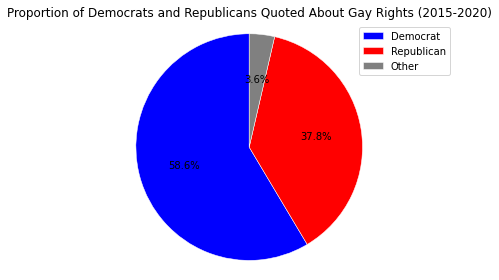

In [20]:
labels = top2.index.str.title()
sizes = top2.ct
colors = ['blue', 'red', 'grey']
patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, autopct='%1.1f%%', wedgeprops = {"edgecolor" : "white",
                      'linewidth': 0.5})
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.title("Proportion of Democrats and Republicans Quoted About Gay Rights (2015-2020)")
plt.tight_layout()
plt.show()

### Occupations

In [21]:
# Create a dataframe with the most common occupations of speakers for each year (for quotes related to gay rights)
occs = pd.DataFrame()
for i, s in enumerate(speakers):
    # approximation here -- dropping duplicates, so potentially choosing the wrong occupation for certain names, but here
    # we are only visualizing the top occupations so it shouldn't be a visible difference
    occupations = pd.DataFrame(americans[americans.label.isin(s)].drop_duplicates(subset=['label']).occupation)
    occupations['occupation'] = occupations['occupation'].astype(str)
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.lstrip("['").rstrip("]'"))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.replace("' '", ' '))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.replace("'\n '", ' '))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.split())
    occupations_list = list(itertools.chain(occupations['occupation']))
    occupations_list  = pd.DataFrame([item for sublist in occupations_list for item in sublist], columns = ['qid'])
    occupations_list = occupations_list[~(occupations_list == 'nan')]
    o = occupations_list.value_counts().head(45)
    o = pd.DataFrame(o).reset_index()
    o.columns = ['qid', 'ct']
    o['year'] = i+2015
    occs = occs.append(o)
occs.head()

,qid,ct,year
0,Q82955,1109,2015
1,Q33999,1016,2015
2,Q36180,841,2015
3,Q10798782,791,2015
4,Q10800557,729,2015


In [22]:
# Create a dataframe of the QIDs and labels for occupations
qids = ['Q82955', 'Q33999', 'Q36180', 'Q10798782', 'Q10800557', 'Q1930187',
       'Q19204627', 'Q28389', 'Q177220', 'Q40348', 'Q3282637', 'Q2405480',
       'Q639669', 'Q2526255', 'Q3665646', 'Q578109', 'Q10871364', 'Q2259451',
       'Q36834', 'Q43845', 'Q488205', 'Q6625963', 'Q1622272', 'Q4610556',
       'Q753110', 'Q855091', 'Q183945', 'Q245068', 'Q2722764', 'Q947873',
       'Q482980', 'Q937857', 'Q33231', 'Q131524', 'Q5137571', 'Q49757',
       'Q201788', 'Q37226', 'Q11774891', 'Q8246794', 'Q19509201', 'Q81096', 'Q1028181', 'Q483501', 'Q15077007']
labels = ['politician', 'actor', 'writer', 'actor', 'actor', 'journalist', \
          'american football player', 'screenwriter', 'singer', 'lawyer', 'film producer', 'actor', \
          'musician', 'film director', 'basketball player', 'television producer', 'baseball player', 'actor', \
          'composer', 'businessperson', 'singer', 'novelist', 'professor', 'model', \
          'songwriter', 'guitarist', 'record producer', 'comedian', 'radio personality', 'television presenter', \
          'author', 'football player', 'photographer', 'entrepreneur', 'basketball coach', 'poet', \
          'historian', 'teacher', 'ice hockey player', 'blogger', 'LGBTI rights activist', 'engineer', 'painter', \
          'artist', 'podcaster']
data = list(zip(qids, labels))
occupation_QID = pd.DataFrame(data, columns = ['qid', 'occupation'])
occupation_QID.head()

,qid,occupation
0,Q82955,politician
1,Q33999,actor
2,Q36180,writer
3,Q10798782,actor
4,Q10800557,actor


In [23]:
# Merge the two dataframes
merged_occ = pd.merge(occs, occupation_QID)
merged_occ.head()

,qid,ct,year,occupation
0,Q82955,1109,2015,politician
1,Q82955,912,2016,politician
2,Q82955,1262,2017,politician
3,Q82955,1276,2018,politician
4,Q82955,1103,2019,politician


In [24]:
merged_occ = merged_occ.drop('qid', axis=1)

In [25]:
merged_occ['logcount'] = np.log(merged_occ.ct)

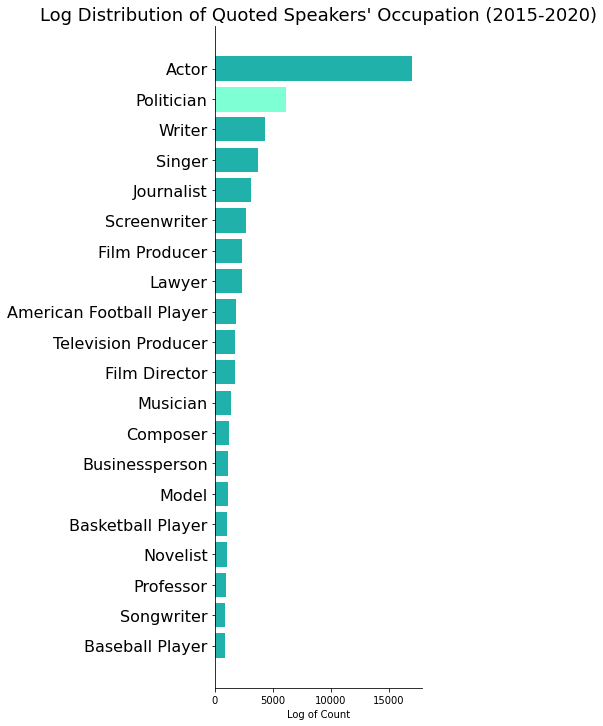

In [26]:
# Distribution of genders for all years
plt.rcParams["figure.figsize"] = (5,10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

barchart_all = merged_occ.drop(['year'], axis=1).groupby('occupation').sum().sort_values(by = "ct", ascending = False).head(20).sort_values(by='ct').reset_index()
barchart = plt.barh(barchart_all['occupation'].str.title(), barchart_all['ct'], color = 'lightseagreen')
barchart[barchart_all.index[barchart_all['occupation'] == 'politician'][0]].set_color('aquamarine')
plt.title("Log Distribution of Quoted Speakers' Occupation (2015-2020)", fontsize = 18)
plt.tight_layout()
plt.xlabel("Log of Count")
plt.yticks(fontsize=16)
plt.show()

In [27]:
# Get the top 10 occupations and count how many should go in the "other" category
top10 = merged_occ.drop(['year'], axis = 1).groupby('occupation').sum().sort_values(by = 'ct', ascending=False).head(10)
other_ct = merged_occ.ct.sum() - top10.ct.sum()
top10.loc['other'] = other_ct
top10

,ct,logcount
occupation,,
actor,16971,184.267835
politician,6018,40.999512
writer,4331,38.999608
singer,3719,67.046307
journalist,3158,36.955421
screenwriter,2733,36.169909
film producer,2342,35.257222
lawyer,2317,35.193733
american football player,1848,33.755999


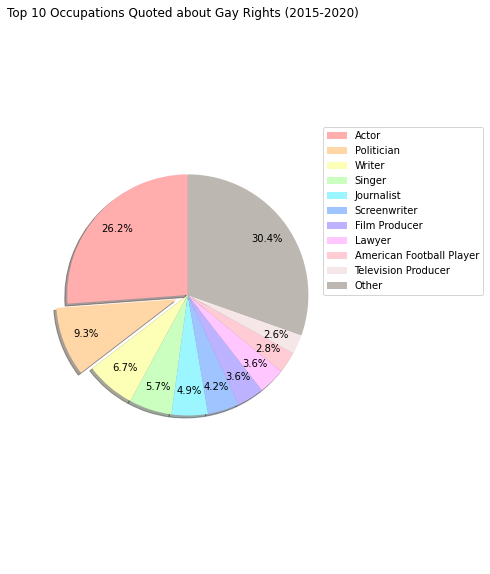

In [31]:
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

labels = top10.index.str.title()
sizes = top10.ct
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#bdb2ff', '#ffc6ff', '#ffccd5', '#f5e6e8', '#bcb8b1']
patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, autopct='%1.1f%%', pctdistance=0.8) #autopct='%1.1f%%'
plt.legend(patches, labels, loc=(1,.5))
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("Top 10 Occupations Quoted about Gay Rights (2015-2020)")
#plt.tight_layout()
plt.show()

### Gender

In [32]:
# Create a dataframe with the gender QIDs and their labels
qids = ['Q6581097', 'Q6581072', 'Q1052281', 'Q48270', 'Q2449503', 'Q1097630', 'Q18116794', \
                           'Q859614', 'Q27679766', 'Q15145779', 'Q12964198', 'Q6581072 Q48270', \
       'Q1097630 Q48270', 'Q6581097 Q18116794', 'Q1052281 Q6581097', 'Q18116794 Q6581097', \
       'Q27679766 Q859614', 'Q15145778', 'Q1984232', 'Q48279', 'Q48279 Q1097630', 'Q505371', \
       'Q48270 Q505371', 'Q189125', 'Q6581097 Q189125', 'Q48270 Q6581072', 'Q48270 Q12964198', \
       'Q1097630 Q48279']
labels = ['male', 'female', 'transgender female', 'non-binary', 'transgender male', \
                           'intersex', 'gender fluid', 'bigender', 'transmasculine', 'female', \
                           'gender queer', 'non-binary', 'intersex non-binary', 'gender fluid', \
         'transgender female', 'gender fluid', 'transmasculine bigender', 'male', 'shemale', 'third gender', \
         'intersex third gender', 'agender', 'non-binary agender', 'transgender person', 'male transgender person', \
         'non-binary', 'gender queer non-binary', 'intersex third gender']
data = list(zip(qids, labels))
gender_QID = pd.DataFrame(data, columns = ['str_qid', 'gender'])
gender_QID.head()

,str_qid,gender
0,Q6581097,male
1,Q6581072,female
2,Q1052281,transgender female
3,Q48270,non-binary
4,Q2449503,transgender male


In [33]:
# For each year, count the number of quotes per gender, add the year and total number of quotes as other columns
counts_gender = pd.DataFrame()
for i, s in enumerate(speakers):
    # approximation here -- some names have multiple entries so we are choosing one at random (not great, but for gender, it is probable that people with the same name have the same gender anyways)
    counts_tmp = pd.DataFrame(americans[americans.label.isin(s)].drop_duplicates(subset=['label']).gender.value_counts()).reset_index()
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.lstrip("['").rstrip("]'"))
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.replace("' '", ' '))
    counts_tmp['index'] = counts_tmp['index'].str.split()
    counts_tmp = counts_tmp.rename(columns = {'index': 'qid', 'gender': 'ct'})
    counts_tmp['str_qid'] = counts_tmp['qid'].apply(lambda x: " ".join(x))
    counts_tmp['year'] = years[i]
    counts_tmp['total_quotes'] = totals[i]
    counts_gender = counts_gender.append(counts_tmp)

    counts_gender = counts_gender.drop('qid', axis=1)
counts_gender.head()

,ct,str_qid,year,total_quotes
0,4606,Q6581097,2015,6724
1,1983,Q6581072,2015,6724
2,67,Q1052281,2015,6724
3,22,Q48270,2015,6724
4,20,Q2449503,2015,6724


In [34]:
# Merge the counts and gender dataframes to get the gender labels
merged_gender = pd.merge(counts_gender, gender_QID, on='str_qid')
merged_gender = merged_gender[~merged_gender.gender.isnull()]
merged_gender.head()

,ct,str_qid,year,total_quotes,gender
0,4606,Q6581097,2015,6724,male
1,3395,Q6581097,2016,4995,male
2,5098,Q6581097,2017,7645,male
3,5239,Q6581097,2018,8036,male
4,4575,Q6581097,2019,7045,male


In [35]:
# Merge repeat categories
merged_gender_new = pd.DataFrame()
for i, yr in enumerate(years):
    temp = merged_gender[merged_gender.year == yr].drop(['str_qid', 'total_quotes', 'year'], axis=1).groupby('gender').sum()
    temp['year'] = yr
    temp['total_quotes'] = totals[i]
    merged_gender_new = pd.concat([merged_gender_new, temp])
merged_gender = merged_gender_new.reset_index()

In [36]:
# Look at the counts on a log scale
merged_gender['logcount'] = np.log(merged_gender.ct.astype(float))

In [37]:
# Only look at genders with a positive count
merged_gender_bar = merged_gender[merged_gender.logcount > 0]

#### Distribution of Gender

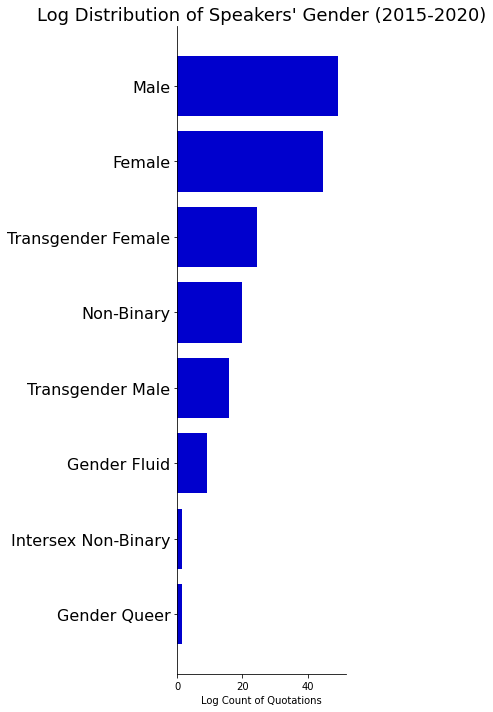

In [38]:
# Distribution of genders for all years
barchart_all = merged_gender_bar.drop(['ct', 'year'], axis=1).groupby('gender').sum().sort_values(by = 'logcount').reset_index()
plt.barh(barchart_all['gender'].str.title(), barchart_all['logcount'], label='_nolegend_', color = 'mediumblue')
plt.title("Log Distribution of Speakers' Gender (2015-2020)", fontsize=18)
plt.xlabel("Log Count of Quotations")
#plt.ylabel("Gender")
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

In [39]:
# Get the top 4 genders and the amount in the "other" category
top4 = merged_gender.drop(['year', 'logcount', 'total_quotes'], axis = 1).groupby('gender').sum().sort_values(by = 'ct', ascending=False).head(4)
other_ct = merged_gender.ct.sum() - top4.ct.sum()
top4.loc['other'] = other_ct
top4

,ct
gender,
male,24158
female,11444
transgender female,397
non-binary,172
other,158


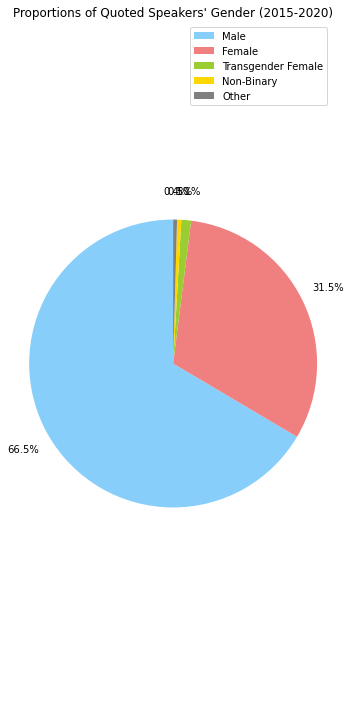

In [40]:
# Look at the gender proportions over all years
labels = top4.index.str.title()
sizes = top4.ct
colors = ['lightskyblue', 'lightcoral', 'yellowgreen', 'gold', 'grey']
patches, texts, junk= plt.pie(sizes, colors=colors, startangle=90, autopct='%1.1f%%', pctdistance = 1.2) 
plt.legend(patches, labels, loc='best')
plt.axis('equal')
plt.title("Proportions of Quoted Speakers' Gender (2015-2020)")
plt.tight_layout()
plt.show()

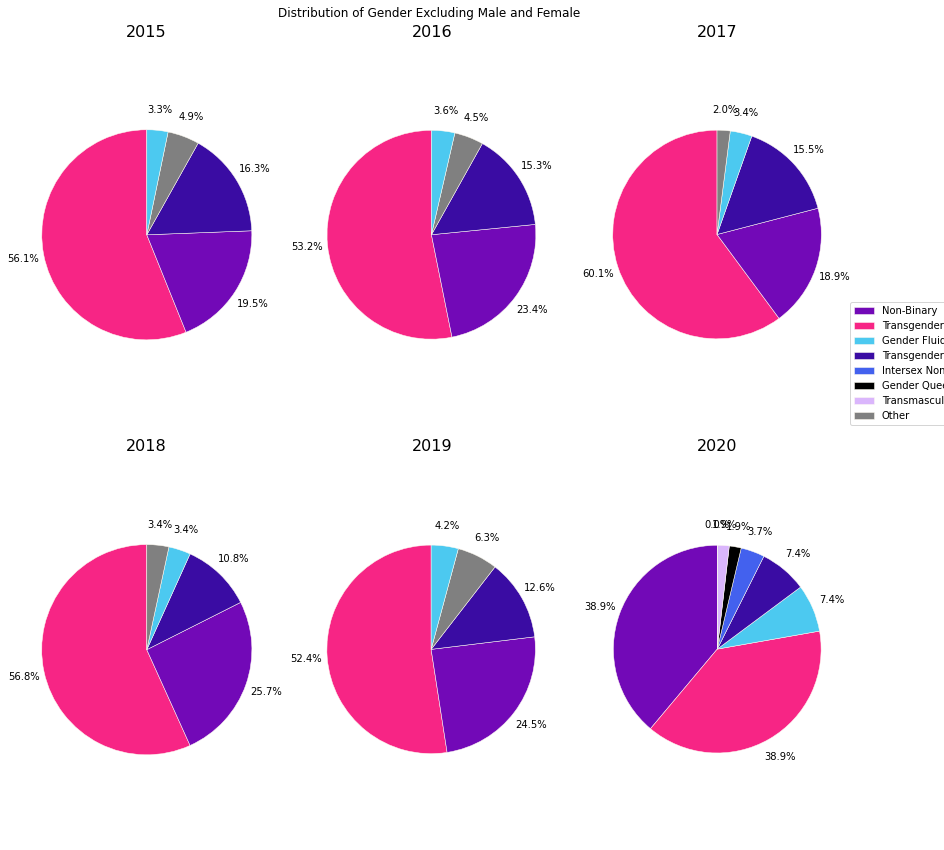

In [49]:
# Look at distribution ignoring male and female
# See significantly more genders in 2020
color_dict = {'Male': 'lightskyblue', 'Female': 'lightcoral', 'Transgender Female': '#f72585', 'Non-Binary': '#7209b7',
       'Transgender Male': '#3a0ca3', 'Gender Fluid': '#4cc9f0', 'Gender Queer': 'black', 
'Intersex Non-Binary': '#4361ee', 'Other': 'grey',  'Transmasculine Bigender': '#dab6fc', 'Gender Queer Non-Binary': 'yellow',
             'Intersex Third Gender': 'teal', 'Male Transgender Person': 'orange', 'Non-Binary Agender': 'red', 'Shemale': 'purple'}
fig,axs = plt.subplots(2,3, figsize=(12,12))
x = 0
y = 0
for i, yr in enumerate(years):
    if (i > 2):
        x = 1
    if ((i-3) == 0):
        y = 0
    if ((i == 1) or (i-3)/1 == 1):
        y = 1
    if (i == 2 or (i-3)/2 == 1):
        y = 2
    # Only at majority genders, put all others into 'other' category
    without_mf = merged_gender[(merged_gender.year == yr) & ~(merged_gender.gender.isin(['male', 'female']))]
    piechart = without_mf[without_mf.ct.astype(float)/without_mf.total_quotes.astype(float) > 0.0005]
    other_ct = without_mf.ct.sum() - piechart.ct.sum()
    piechart = piechart.drop(['year', 'logcount', 'total_quotes'], axis=1).set_index('gender')
    piechart.loc['other'] = other_ct

    labels = piechart.sort_values(by='ct', ascending=False).index.str.title()
    sizes = piechart.sort_values(by='ct', ascending=False).ct
    #colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'grey']
    color_map = [color_dict[label] for label in labels]
    patches, texts, junk = axs[x,y].pie(sizes, colors=color_map, startangle=90, autopct='%1.1f%%', pctdistance=1.2, wedgeprops = 
                                                                                            {"edgecolor" : "#fffcf2", 'linewidth': 0.5})

    axs[x,y].axis('equal')
    axs[x,y].set_title(yr, fontsize=16)

fig.legend(patches, labels, loc=(.9, .5), ncol=1)
fig.suptitle("Distribution of Gender Excluding Male and Female", fontsize=16)
fig.tight_layout()

In [ ]:
# Here we see that the number of people quoted speaking about gay rights who identify as non-binary significantly jumps
# from 2019 to 2020

## Topic Modeling

In [3]:
from lda_functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanharrington/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

In [53]:
# Read in politician-specific dataframes
df15 = pd.read_csv("../Downloads/df15.csv")
df16 = pd.read_csv("../Downloads/df16.csv")
df17 = pd.read_csv("../Downloads/df17.csv")
df18 = pd.read_csv("../Downloads/df18.csv")
df19 = pd.read_csv("../Downloads/df19.csv")
df20 = pd.read_csv("../Downloads/df20.csv")

In [10]:
def remove_bi_and_ally(df):
    df = df[~(df.quotation.str.contains("bi") & ~df.quotation.isin(words))]
    df = df[~(df.quotation.str.contains("ally") & ~df.quotation.isin(words))]
    df = df.reset_index(drop=True)
    return df

In [11]:
# a lot of quotes with "bi" and "ally" aren't relevant so remove the rows that include these and don't include other relevant words 
df15 = remove_bi_and_ally(df15)
df16 = remove_bi_and_ally(df16)
df17 = remove_bi_and_ally(df17)
df18 = remove_bi_and_ally(df18)
df19 = remove_bi_and_ally(df19)
df20 = remove_bi_and_ally(df20)


 2015 

[(0,
  '0.033*"right" + 0.021*"woman" + 0.012*"discrimination" + 0.010*"equality" + '
  '0.009*"blood" + 0.008*"man" + 0.007*"love" + 0.007*"thing" + '
  '0.007*"community" + 0.006*"friend"'),
 (1,
  '0.016*"gender" + 0.008*"woman" + 0.007*"race" + 0.007*"time" + 0.006*"gay" '
  '+ 0.006*"vote" + 0.006*"country" + 0.005*"people" + 0.005*"play" + '
  '0.005*"young"'),
 (2,
  '0.039*"marriage" + 0.016*"issue" + 0.014*"sex" + 0.013*"state" + '
  '0.010*"right" + 0.009*"law" + 0.009*"couple" + 0.009*"community" + '
  '0.008*"gay" + 0.007*"believe"')]


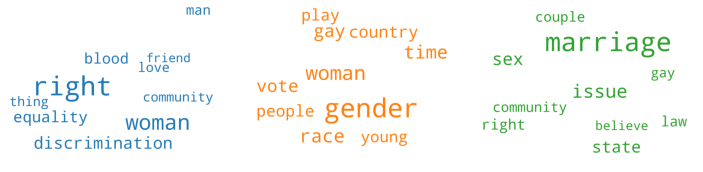


 2016 

[(0,
  '0.014*"woman" + 0.012*"gender" + 0.010*"gay" + 0.009*"issue" + 0.007*"get" '
  '+ 0.007*"anti" + 0.006*"time" + 0.006*"support" + 0.005*"people" + '
  '0.005*"country"'),
 (1,
  '0.017*"community" + 0.014*"woman" + 0.010*"equality" + 0.009*"marriage" + '
  '0.008*"right" + 0.008*"man" + 0.008*"state" + 0.007*"work" + 0.007*"know" + '
  '0.006*"issue"'),
 (2,
  '0.016*"right" + 0.014*"community" + 0.013*"student" + 0.012*"identity" + '
  '0.010*"discrimination" + 0.010*"law" + 0.008*"school" + 0.008*"protect" + '
  '0.008*"gender" + 0.007*"individual"')]


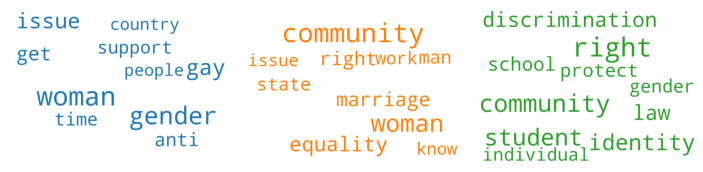


 2017 

[(0,
  '0.016*"military" + 0.011*"gender" + 0.011*"serve" + 0.009*"race" + '
  '0.005*"continue" + 0.005*"regardless" + 0.005*"woman" + 0.005*"individual" '
  '+ 0.005*"allow" + 0.004*"homosexuality"'),
 (1,
  '0.014*"right" + 0.013*"community" + 0.010*"discrimination" + 0.010*"issue" '
  '+ 0.010*"woman" + 0.008*"identity" + 0.008*"country" + 0.007*"military" + '
  '0.007*"student" + 0.007*"people"'),
 (2,
  '0.017*"right" + 0.011*"community" + 0.010*"thing" + 0.010*"work" + '
  '0.006*"human" + 0.006*"candidate" + 0.005*"life" + 0.005*"happen" + '
  '0.005*"woman" + 0.005*"need"')]


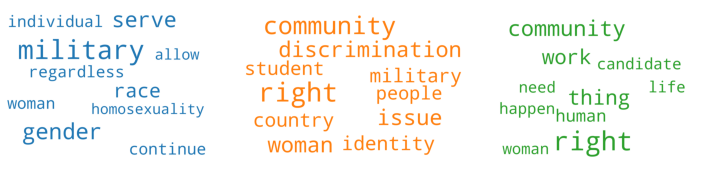


 2018 

[(0,
  '0.018*"gender" + 0.013*"race" + 0.010*"base" + 0.009*"identity" + '
  '0.008*"state" + 0.007*"serve" + 0.007*"discrimination" + 0.007*"sex" + '
  '0.007*"sexual_orientation" + 0.006*"military"'),
 (1,
  '0.009*"good" + 0.009*"gay" + 0.007*"get" + 0.006*"look" + 0.006*"thing" + '
  '0.006*"great" + 0.005*"issue" + 0.005*"state" + 0.005*"year" + '
  '0.004*"start"'),
 (2,
  '0.032*"right" + 0.022*"woman" + 0.019*"community" + 0.010*"work" + '
  '0.008*"equality" + 0.007*"issue" + 0.007*"need" + 0.006*"protect" + '
  '0.006*"member" + 0.006*"stand"')]


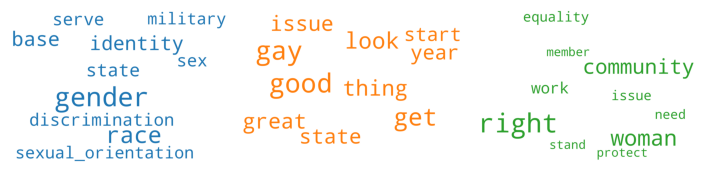


 2019 

[(0,
  '0.019*"right" + 0.015*"community" + 0.014*"discrimination" + '
  '0.012*"equality" + 0.010*"woman" + 0.010*"child" + 0.009*"work" + '
  '0.008*"protect" + 0.008*"fight" + 0.008*"identity"'),
 (1,
  '0.012*"gender" + 0.011*"woman" + 0.011*"race" + 0.010*"gay" + '
  '0.008*"person" + 0.008*"diversity" + 0.008*"country" + 0.007*"year" + '
  '0.007*"know" + 0.007*"community"'),
 (2,
  '0.019*"community" + 0.018*"people" + 0.010*"include" + 0.010*"member" + '
  '0.008*"time" + 0.007*"well" + 0.007*"right" + 0.006*"country" + '
  '0.006*"policy" + 0.006*"family"')]


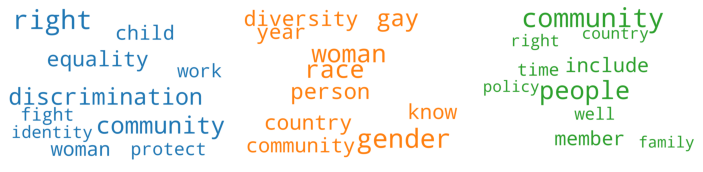


 2020 

[(0,
  '0.015*"right" + 0.012*"community" + 0.011*"woman" + 0.008*"time" + '
  '0.007*"equality" + 0.007*"support" + 0.006*"fight" + 0.006*"work" + '
  '0.006*"family" + 0.006*"year"'),
 (1,
  '0.011*"gender" + 0.007*"race" + 0.006*"divide" + 0.006*"country" + '
  '0.006*"great" + 0.005*"candidate" + 0.005*"look" + 0.005*"discrimination" + '
  '0.005*"good" + 0.004*"sexuality"'),
 (2,
  '0.015*"community" + 0.008*"get" + 0.007*"woman" + 0.007*"number" + '
  '0.007*"gender" + 0.007*"thing" + 0.006*"vote" + 0.006*"need" + 0.006*"know" '
  '+ 0.006*"person"')]


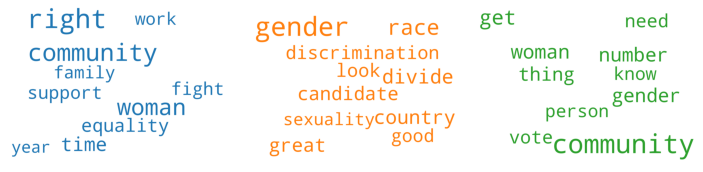

In [12]:
# Topics for politicians 
dfs = [df15, df16, df17, df18, df19, df20]
for i, df in enumerate(dfs):
    print("\n", i + 2015, "\n")
    # only consider words that we didn't provide and remove some other irrelevant words
    df_clean = df.quotation.apply(lambda x: remove_keywords(x))
    data_lemmatized = nlp_pipe(df_clean)
    corpus, id2word = create_corpus(data_lemmatized)
    p, c, lda_model = run_lda(data_lemmatized, corpus, id2word, 3)
    word_bubble(lda_model, 3)


 2015 

[(0,
  '0.024*"right" + 0.023*"marriage" + 0.015*"issue" + 0.012*"gender" + '
  '0.012*"sex" + 0.009*"discrimination" + 0.009*"equality" + 0.009*"law" + '
  '0.008*"state" + 0.008*"support"'),
 (1,
  '0.048*"community" + 0.020*"family" + 0.014*"lesbian" + '
  '0.012*"homosexuality" + 0.011*"human" + 0.009*"live" + 0.007*"member" + '
  '0.006*"movement" + 0.006*"sexual" + 0.006*"choose"'),
 (2,
  '0.024*"woman" + 0.016*"gay" + 0.016*"man" + 0.012*"thing" + 0.011*"time" + '
  '0.011*"love" + 0.011*"way" + 0.010*"feel" + 0.009*"people" + 0.008*"life"')]


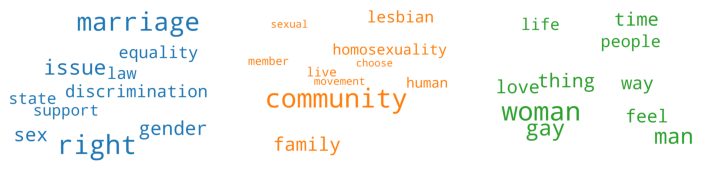


 2016 

[(0,
  '0.015*"right" + 0.014*"law" + 0.013*"discrimination" + 0.012*"community" + '
  '0.012*"state" + 0.011*"student" + 0.011*"identity" + 0.011*"support" + '
  '0.009*"bathroom" + 0.009*"marriage"'),
 (1,
  '0.027*"gender" + 0.015*"issue" + 0.014*"right" + 0.013*"race" + '
  '0.009*"believe" + 0.008*"work" + 0.007*"woman" + 0.006*"change" + '
  '0.006*"care" + 0.005*"way"'),
 (2,
  '0.021*"woman" + 0.015*"gay" + 0.015*"man" + 0.013*"community" + '
  '0.011*"feel" + 0.010*"thing" + 0.010*"life" + 0.009*"people" + 0.008*"love" '
  '+ 0.008*"live"')]


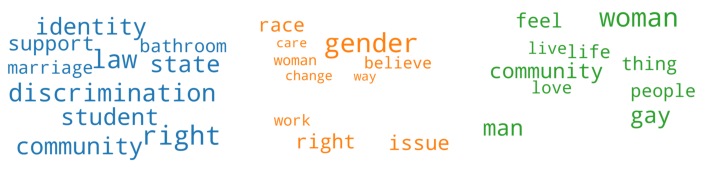


 2017 

[(0,
  '0.026*"gender" + 0.014*"race" + 0.013*"issue" + 0.013*"identity" + '
  '0.012*"need" + 0.011*"sex" + 0.010*"student" + 0.009*"base" + 0.009*"work" '
  '+ 0.007*"change"'),
 (1,
  '0.031*"community" + 0.030*"right" + 0.011*"support" + 0.011*"equality" + '
  '0.011*"military" + 0.011*"discrimination" + 0.010*"country" + 0.009*"serve" '
  '+ 0.009*"marriage" + 0.008*"law"'),
 (2,
  '0.026*"woman" + 0.018*"man" + 0.012*"thing" + 0.011*"life" + 0.011*"time" + '
  '0.010*"way" + 0.010*"gay" + 0.010*"love" + 0.010*"feel" + 0.008*"people"')]


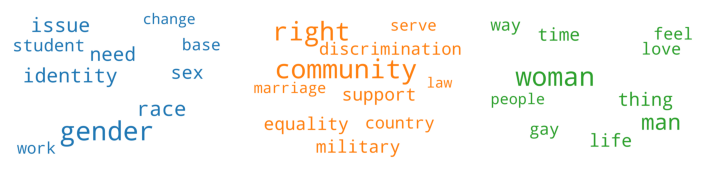


 2018 

[(0,
  '0.016*"man" + 0.015*"gender" + 0.011*"feel" + 0.011*"way" + 0.011*"time" + '
  '0.011*"woman" + 0.011*"thing" + 0.010*"gay" + 0.010*"love" + 0.009*"life"'),
 (1,
  '0.025*"community" + 0.021*"right" + 0.020*"woman" + 0.009*"support" + '
  '0.009*"equality" + 0.009*"work" + 0.008*"issue" + 0.006*"discrimination" + '
  '0.006*"country" + 0.006*"continue"'),
 (2,
  '0.023*"sex" + 0.019*"marriage" + 0.011*"couple" + 0.010*"homosexuality" + '
  '0.009*"person" + 0.007*"homosexual" + 0.006*"church" + 0.005*"night" + '
  '0.005*"single" + 0.005*"call"')]


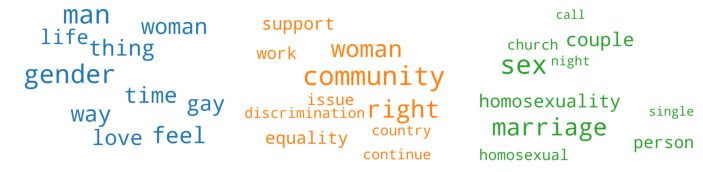


 2019 

[(0,
  '0.019*"man" + 0.017*"woman" + 0.014*"feel" + 0.013*"gay" + 0.013*"time" + '
  '0.012*"love" + 0.012*"thing" + 0.012*"way" + 0.010*"life" + 0.010*"person"'),
 (1,
  '0.019*"child" + 0.018*"story" + 0.016*"different" + 0.011*"sexuality" + '
  '0.010*"gender" + 0.010*"young" + 0.008*"parent" + 0.008*"culture" + '
  '0.008*"film" + 0.007*"artist"'),
 (2,
  '0.024*"community" + 0.013*"right" + 0.013*"gender" + 0.010*"woman" + '
  '0.010*"work" + 0.008*"support" + 0.008*"identity" + 0.007*"need" + '
  '0.007*"equality" + 0.007*"race"')]


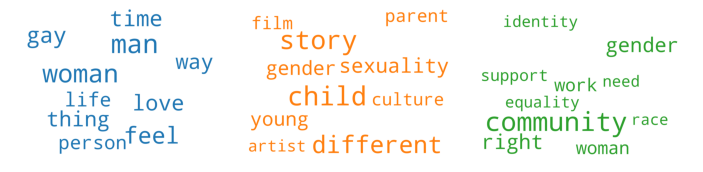


 2020 

[(0,
  '0.015*"community" + 0.012*"look" + 0.011*"woman" + 0.009*"man" + '
  '0.009*"get" + 0.008*"home" + 0.008*"thing" + 0.008*"love" + 0.008*"change" '
  '+ 0.007*"husband"'),
 (1,
  '0.015*"right" + 0.014*"talk" + 0.012*"gender" + 0.010*"woman" + '
  '0.009*"equality" + 0.009*"community" + 0.008*"race" + 0.008*"fight" + '
  '0.006*"identity" + 0.006*"support"'),
 (2,
  '0.014*"woman" + 0.011*"gay" + 0.011*"time" + 0.008*"community" + '
  '0.008*"man" + 0.006*"gender" + 0.005*"person" + 0.005*"black" + '
  '0.005*"year" + 0.005*"world"')]


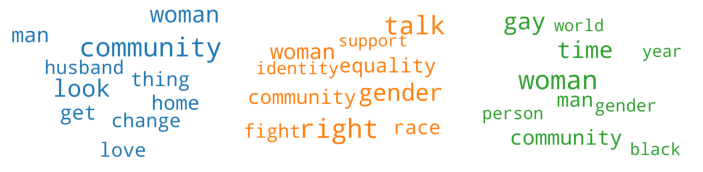

In [13]:
# Topics for all Americans
dfs = [df15_all, df16_all, df17_all, df18_all, df19_all, df20_all]
for i, df in enumerate(dfs):
    print("\n", i + 2015, "\n")
    # only consider words that we didn't provide and remove some other irrelevant words
    df_clean = df.quotation.apply(lambda x: remove_keywords(x))
    data_lemmatized = nlp_pipe(df_clean)
    corpus, id2word = create_corpus(data_lemmatized)
    p, c, lda_model = run_lda(data_lemmatized, corpus, id2word, 3)
    word_bubble(lda_model, 3)

### Topics Overall

In [4]:
dfs = [df15_all, df16_all, df17_all, df18_all, df19_all, df20_all]
df_all = pd.concat(dfs)
# only consider words that we didn't provide and remove some other irrelevant words
df_clean = df_all.quotation.apply(lambda x: remove_keywords(x))
data_lemmatized = nlp_pipe(df_clean)

In [5]:
corpus, id2word = create_corpus(data_lemmatized)
p, c, lda_model = run_lda(data_lemmatized, corpus, id2word, 7)

[(0,
  '0.142*"woman" + 0.083*"man" + 0.039*"black" + 0.024*"color" + '
  '0.022*"female" + 0.020*"sexual" + 0.015*"male" + 0.013*"pay" + '
  '0.012*"white" + 0.012*"level"'),
 (1,
  '0.057*"community" + 0.019*"history" + 0.018*"work" + 0.017*"lead" + '
  '0.016*"year" + 0.016*"job" + 0.016*"long" + 0.016*"support" + '
  '0.015*"recognize" + 0.015*"equality"'),
 (2,
  '0.059*"family" + 0.030*"tremendous" + 0.019*"friend" + 0.016*"call" + '
  '0.013*"home" + 0.012*"homosexuality" + 0.011*"hate" + 0.010*"church" + '
  '0.010*"leave" + 0.009*"number"'),
 (3,
  '0.074*"gender" + 0.036*"race" + 0.032*"identity" + 0.022*"care" + '
  '0.021*"base" + 0.017*"student" + 0.017*"diversity" + 0.017*"age" + '
  '0.016*"create" + 0.015*"school"'),
 (4,
  '0.123*"child" + 0.049*"issue" + 0.043*"remind" + 0.039*"sex" + '
  '0.027*"marriage" + 0.023*"parent" + 0.015*"couple" + 0.014*"government" + '
  '0.014*"view" + 0.013*"political"'),
 (5,
  '0.029*"love" + 0.023*"important" + 0.019*"point" + 0.018*"

In [6]:
def word_bubble1(lda_model, num_topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='Paired',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, int(num_topics/2), figsize=(17,17), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < 7:
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().axis('off')

    fig.delaxes(axes[1,3])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

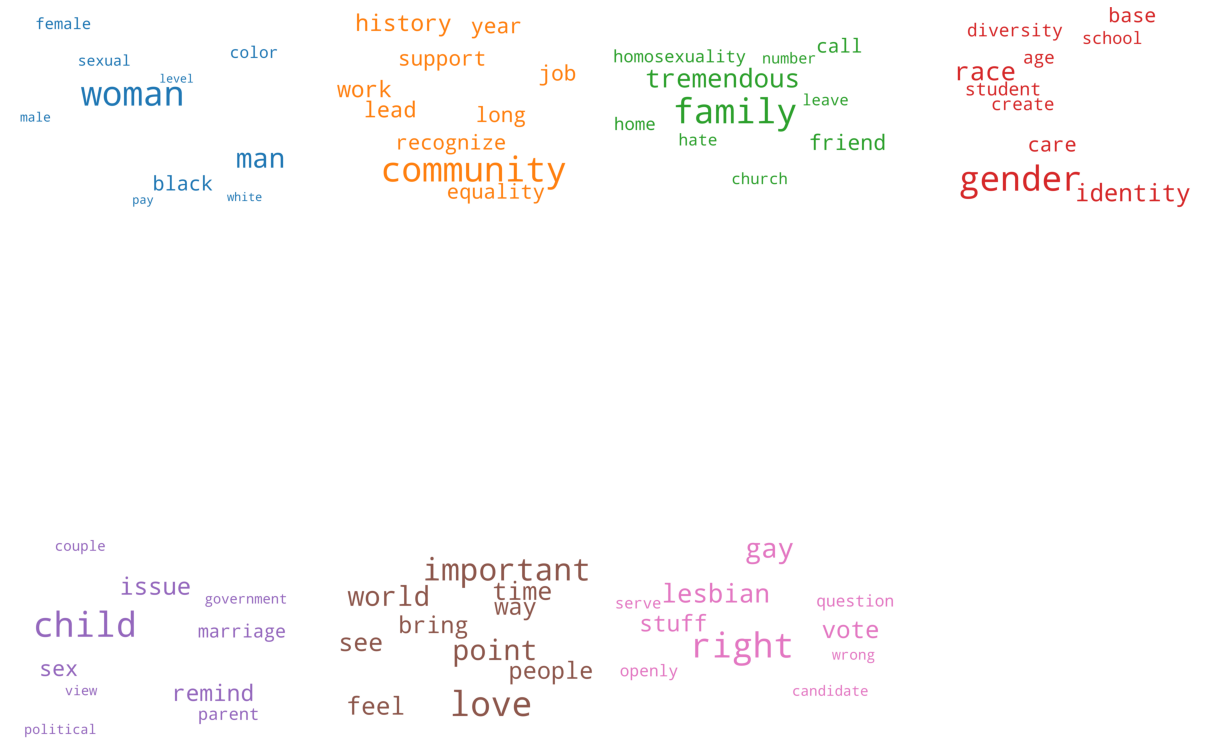

In [7]:
word_bubble1(lda_model, 8)

In [8]:
p = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
#pyLDAvis.save_html(p, 'lda_overall.html')

In [9]:
data =  pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(data)

/Users/meghanharrington/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/meghanharrington/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/meghanharrington/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/meghanharrington/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import rel

### Sentiment Analysis

In [50]:
nlp = spacy.load('en_core_web_sm')

In [51]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']

In [54]:
# Look at number of positive/negative/neutral quotations for politicians and for all speakers
analyzer = SentimentIntensityAnalyzer()

#List of dataframes with quotes from politicians and quotes from americans in general
dfs = [df15, df16, df17, df18, df19, df20]
dfs_all = [df15_all, df16_all, df17_all, df18_all, df19_all, df20_all]
p = []
n = []
c = []
p_all = []
n_all = []
c_all = []

# Compute the compound sentiments for each quotation for each year
for i, df in enumerate(dfs):
    sents = [analyzer.polarity_scores(quotation)['compound'] for quotation in df.quotation]
    p.append(sum(np.array(sents)>=0.05))
    n.append(sum(np.array(sents)<=-0.05))
    c.append(sum(np.abs(np.array(sents))<0.05))

for i, df in enumerate(dfs_all):
    sents = [analyzer.polarity_scores(quotation)['compound'] for quotation in df.quotation]
    p_all.append(sum(np.array(sents)>=0.05))
    n_all.append(sum(np.array(sents)<=-0.05))
    c_all.append(sum(np.abs(np.array(sents))<0.05))

prop_pos = []
prop_neg = []
prop_neu = []

prop_pos_all = []
prop_neg_all = []
prop_neu_all = []

# Compute the proportion of positive, negative, and neutral quotes for each year
for i in range(6):
    pos = p[i]/(p[i] + n[i] + c[i])
    neg = n[i]/(p[i] + n[i] + c[i])
    neu = c[i]/(p[i] + n[i] + c[i])
    prop_pos.append(pos)
    prop_neg.append(neg)
    prop_neu.append(neu)
    
    pos_all = p_all[i]/(p_all[i] + n_all[i] + c_all[i])
    neg_all = n_all[i]/(p_all[i] + n_all[i] + c_all[i])
    neu_all = c_all[i]/(p_all[i] + n_all[i] + c_all[i])
    prop_pos_all.append(pos_all)
    prop_neg_all.append(neg_all)
    prop_neu_all.append(neu_all)

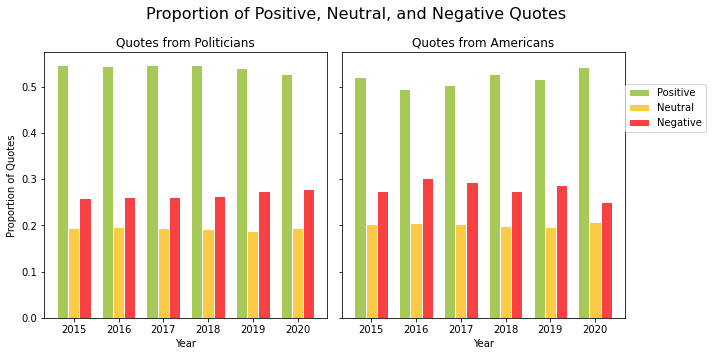

In [70]:
# Plot the proportion of positive, negative, and neutral quotations for each year
fig, axs = plt.subplots(1,2, sharey=True)
fig.set_size_inches(10, 5)

barWidth = 0.25
 
bars1 = [prop_pos, prop_pos_all]
bars2 = [prop_neu, prop_neu_all]
bars3 = [prop_neg, prop_neg_all]
 
r1 = np.arange(len(bars1[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
for i in range(2):
    axs[i].bar(r1, bars1[i], color='#a7c957', width=barWidth, edgecolor='white', label='Positive')
    axs[i].bar(r2, bars2[i], color='#fcca46', width=barWidth, edgecolor='white', label='Neutral')
    axs[i].bar(r3, bars3[i], color='#f94144', width=barWidth, edgecolor='white', label='Negative')


    axs[i].set_xlabel('Year')
    axs[0].set_ylabel('Proportion of Quotes')
    #axs[i].set_title("Proportion of Positive, Neutral, and Negative Quotes Each Year")
    axs[i].set_xticks([r + barWidth for r in range(len(bars1[0]))])
    axs[i].set_xticklabels(['2015', '2016', '2017', '2018', '2019', '2020'])

axs[0].set_title('Quotes from Politicians')
axs[1].set_title('Quotes from Americans')

plt.legend(loc=(1,0.7))
fig.suptitle("Proportion of Positive, Neutral, and Negative Quotes", fontsize=16)
fig.tight_layout()
#fig.gca().spines['top'].set_visible(False)
#fig.gca().spines['right'].set_visible(False)

In [61]:
# Get positive and negative sentiments for each doc
dfs = [df15, df16, df17, df18, df19, df20]
dfs_all = [df15_all, df16_all, df17_all, df18_all, df19_all, df20_all]

positive_sents = []
negative_sents = []

positive_sents_all = []
negative_sents_all = []

for i, df in enumerate(dfs):
    positive_sent = []
    negative_sent = []
    [positive_sent.append(analyzer.polarity_scores(quotation)['pos']) for quotation in df.quotation]
    [negative_sent.append(analyzer.polarity_scores(quotation)['neg']) for quotation in df.quotation]
    positive_sents.append(positive_sent)
    negative_sents.append(negative_sent)
    
for i, df in enumerate(dfs_all):
    positive_sent = []
    negative_sent = []
    [positive_sent.append(analyzer.polarity_scores(quotation)['pos']) for quotation in df.quotation]
    [negative_sent.append(analyzer.polarity_scores(quotation)['neg']) for quotation in df.quotation]
    positive_sents_all.append(positive_sent)
    negative_sents_all.append(negative_sent)

In [62]:
# Create a dataframe of the sentiment lists
positive_sents_T = list(map(list, itertools.zip_longest(*positive_sents, fillvalue=None)))
negative_sents_T = list(map(list, itertools.zip_longest(*negative_sents, fillvalue=None)))

pos_df = pd.DataFrame(positive_sents_T, columns = years)
neg_df = pd.DataFrame(negative_sents_T, columns = years)
pos_df.head()

,2015,2016,2017,2018,2019,2020
0,0.067,0.000,0.000,0.076,0.130,0.000
1,0.171,0.297,0.215,0.065,0.027,0.254
2,0.064,0.207,0.070,0.368,0.073,0.065
3,0.380,0.237,0.000,0.278,0.000,0.094
4,0.551,0.000,0.000,0.107,0.085,0.055


In [63]:
# Create a dataframe of the sentiment lists for americans
positive_sents_all_T = list(map(list, itertools.zip_longest(*positive_sents_all, fillvalue=None)))
negative_sents_all_T = list(map(list, itertools.zip_longest(*negative_sents_all, fillvalue=None)))

pos_df_all = pd.DataFrame(positive_sents_all_T, columns = years)
neg_df_all = pd.DataFrame(negative_sents_all_T, columns = years)

In [64]:
# Calculate the mean sentiment for each year and category
pos_mean = pos_df.mean()
neg_mean = neg_df.mean()

pos_mean_all = pos_df_all.mean()
neg_mean_all = neg_df_all.mean()

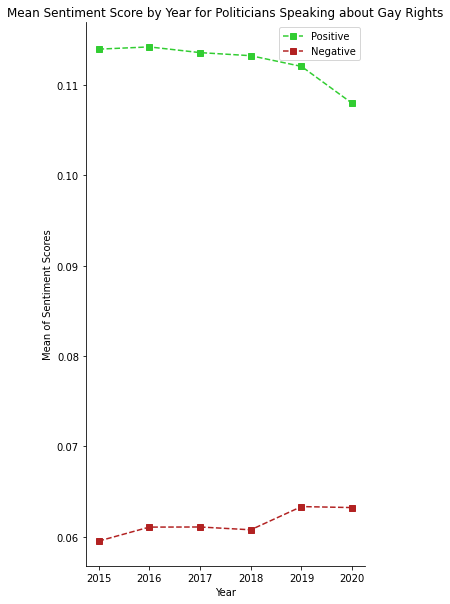

In [71]:
# Plot the mean sentiment scores for the politicians
x = pos_df.columns
plt.plot([str(i) for i in x], pos_mean, linestyle='dashed', marker='s', label = "Positive", color= "limegreen")
plt.plot([str(i) for i in x], neg_mean, linestyle='dashed', marker='s', label = "Negative", color = "firebrick")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Mean of Sentiment Scores")
plt.legend()
plt.title("Mean Sentiment Score by Year for Politicians Speaking about Gay Rights")
plt.show()

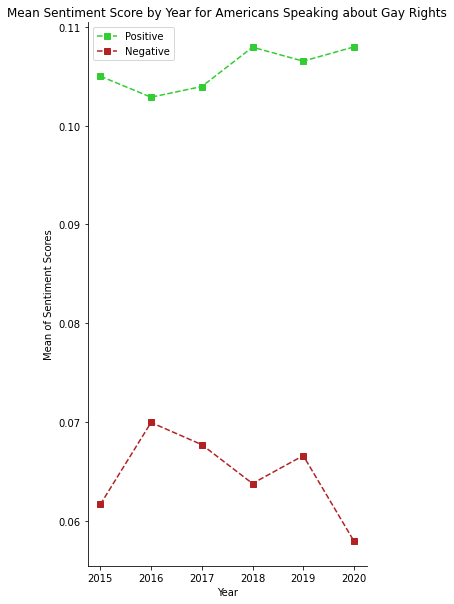

In [72]:
# Plot the mean sentiment scores for americans
x = pos_df_all.columns
plt.plot([str(i) for i in x], pos_mean_all, linestyle='dashed', marker='s', label = "Positive", color= "limegreen")
plt.plot([str(i) for i in x], neg_mean_all, linestyle='dashed', marker='s', label = "Negative", color = "firebrick")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Mean of Sentiment Scores")
plt.legend()
plt.title("Mean Sentiment Score by Year for Americans Speaking about Gay Rights")
plt.show()

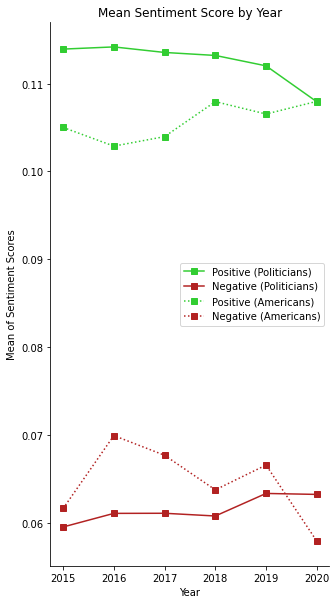

In [73]:
# Plot them together
x = pos_df.columns

colors = ["green", "red", "blue"]
linestyles = ['solid', "dotted"]

plt.plot([str(i) for i in x], pos_mean, linestyle='solid', marker='s', label = "Positive (Politicians)", color= "limegreen")
plt.plot([str(i) for i in x], neg_mean, linestyle='solid', marker='s', label = "Negative (Politicians)", color = "firebrick")
plt.plot([str(i) for i in x], pos_mean_all, linestyle='dotted', marker='s', label = "Positive (Americans)", color= "limegreen")
plt.plot([str(i) for i in x], neg_mean_all, linestyle='dotted', marker='s', label = "Negative (Americans)",color = "firebrick")



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Mean of Sentiment Scores")
plt.legend()
plt.title("Mean Sentiment Score by Year")
plt.show()

In [75]:
# Get lengths of sentiment score lists
lengths = []
for i in range(len(positive_sents)):
    lengths.append(len(positive_sents[i]))
lengths

lengths_all = []
for i in range(len(positive_sents_all)):
    lengths_all.append(len(positive_sents_all[i]))
lengths_all

[23591, 15092, 27336, 27043, 25926, 5016]

In [76]:
# Only look at quotes with a strong sentiment score (> 0.7)
highprop_pos = []
highprop_neg = []

highprop_pos_all = []
highprop_neg_all = []

# Calculate how many quotes for each year have a sentiment score above 0.7
for i, yr in enumerate(years):
    highprop_pos.append(len(pos_df[yr][pos_df[yr] > 0.7])/lengths[i])
    highprop_neg.append(len(neg_df[yr][neg_df[yr] > 0.7])/lengths[i])
    

for i, yr in enumerate(years):
    highprop_pos_all.append(len(pos_df_all[yr][pos_df_all[yr] > 0.7])/lengths_all[i])
    highprop_neg_all.append(len(neg_df_all[yr][neg_df_all[yr] > 0.7])/lengths_all[i])

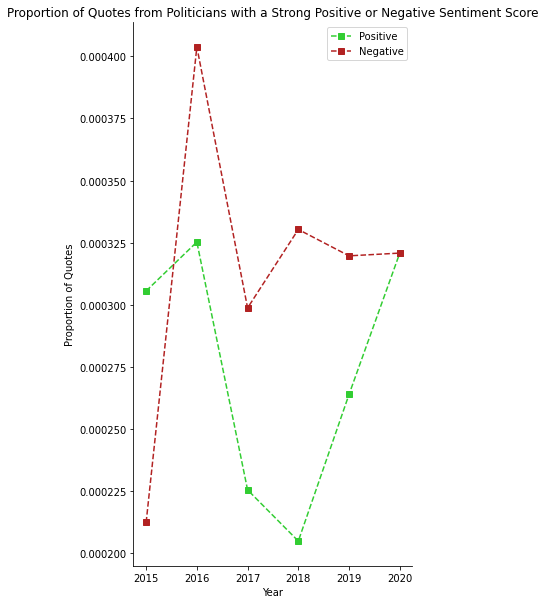

In [77]:
# Plot the proportion of quotes with strong positive/negative sentiment for each year for politicians
x = pos_df.columns
plt.plot([str(i) for i in x], highprop_pos, linestyle='dashed', marker='s', label = "Positive", color= "limegreen")
plt.plot([str(i) for i in x], highprop_neg, linestyle='dashed', marker='s', label = "Negative", color = "firebrick")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Proportion of Quotes")
plt.legend()
plt.title("Proportion of Quotes from Politicians with a Strong Positive or Negative Sentiment Score")
plt.show()

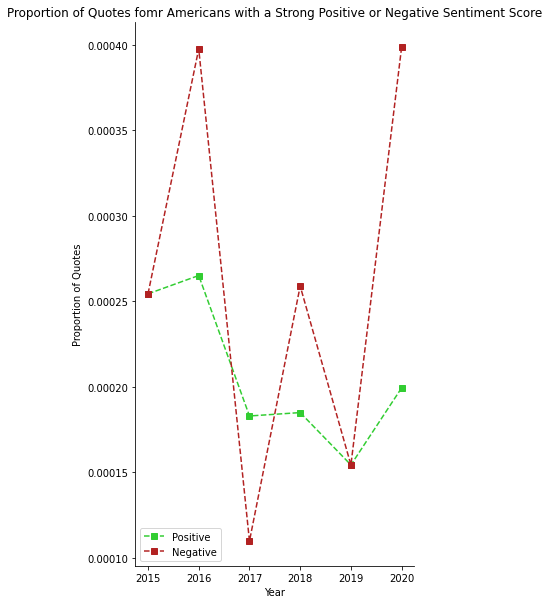

In [78]:
# Plot the proportion of quotes with strong positive/negative sentiment for each year for Americans
x = pos_df_all.columns
plt.plot([str(i) for i in x], highprop_pos_all, linestyle='dashed', marker='s', label = "Positive", color= "limegreen")
plt.plot([str(i) for i in x], highprop_neg_all, linestyle='dashed', marker='s', label = "Negative", color = "firebrick")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Proportion of Quotes")
plt.legend()
plt.title("Proportion of Quotes fomr Americans with a Strong Positive or Negative Sentiment Score")
plt.show()

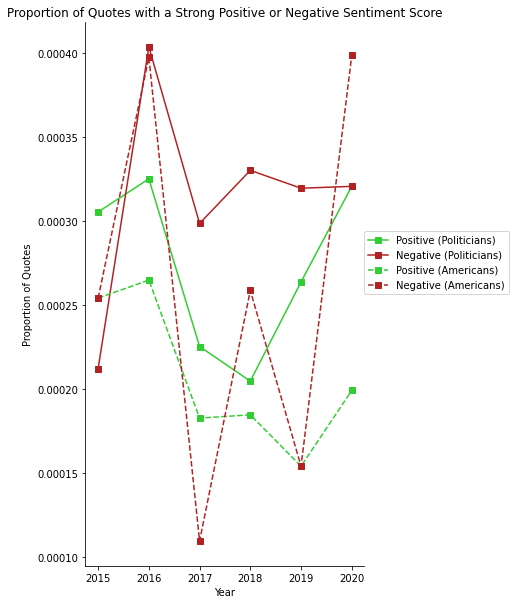

In [82]:
# Plot them together
x = pos_df_all.columns
plt.plot([str(i) for i in x], highprop_pos, linestyle='solid', marker='s', label = "Positive (Politicians)", color= "limegreen")
plt.plot([str(i) for i in x], highprop_neg, linestyle='solid', marker='s', label = "Negative (Politicians)", color = "firebrick")


plt.plot([str(i) for i in x], highprop_pos_all, linestyle='dashed', marker='s', label = "Positive (Americans)", color= "limegreen")
plt.plot([str(i) for i in x], highprop_neg_all, linestyle='dashed', marker='s', label = "Negative (Americans)", color = "firebrick")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Year")
plt.ylabel("Proportion of Quotes")
plt.legend(loc = (1,.5))
plt.title("Proportion of Quotes with a Strong Positive or Negative Sentiment Score")
plt.show()

In [ ]:
# Here we can see that the Americans are generally more positive overall than politicians
# Also an interesting drop in negativity in 2017